# This notebook showcases the beamconv HWP class
We start by importing the relevant libraries and items

In [1]:
import os, pickle, time
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from beamconv import ScanStrategy, Beam, tools
import qpoint as qp
import seaborn as sns
from scipy.fftpack import fft, ifft
sns.set()
%matplotlib inline

First, we instantiate a `Beam`, which creates a `HWP` instance and a `hwp_mueller` as class variables. By default, the `hwp_mueller`, and the `HWP` class' attribute, `stack`, are set to None.

In [2]:
beamy = Beam(name='beamy', sensitive_freq=150) 

In [3]:
print(beamy)
print(beamy.hwp)
print(beamy.hwp.stack)
print(beamy.hwp_mueller)

name    : beamy 
btype   : Gaussian 
alive   : True 
FWHM    : 43.2 arcmin 
az      : 0.0 deg 
el      : 0.0 deg 
polang  : 0.0 deg
po_file : None 

None
None


We assign a stack to hwp from one of our predefined models (there are nine, see the source code for their names and characteristics). Stacks are made of slices of specific thickness, with a name, a type (isotropic or uniaxial), and index/indices (if the material is uniaxial) and losses (the imaginary part of the index). The slices are supposed to extend to infinity in the xy plane, and be stacked in the z axis.

In [4]:
beamy.hwp.choose_HWP_model(model_name='SPIDER_95')
print(beamy.hwp.stack)



______________________________________________________


Layer 1: Thickness 0.000427


Material: Quartz
Material Type: isotropic
Refractive Index: 1.951000
Loss tangent: 0.001200


______________________________________________________

Layer 2: Thickness 0.004930


Material: Sapphire at 4K
Material Type: uniaxial
Refractive Index (ordinary): 3.019000
Refractive Index (extraordinary): 3.336000
Loss Tangent (ordinary): 0.000230
Loss Tangent (extraordinary): 0.000125


	 Angle of extraordinary axis to x-axis: 0.000000
______________________________________________________

Layer 3: Thickness 0.000427


Material: Quartz
Material Type: isotropic
Refractive Index: 1.951000
Loss tangent: 0.001200


______________________________________________________



We can then call the `HWP` method `compute_mueller` for a particular frequency and angle of incidence to calculate `beamy`'s `hwp_mueller`.

In [5]:
beamy.hwp_mueller = beamy.hwp.compute_mueller(freq=100, vartheta= 0)
#frequency in GHz, vartheta is the incidence angle of the beam on the HWP's surface. in degrees
print(beamy.hwp_mueller)

[[ 0.94375106 -0.00620058  0.          0.        ]
 [-0.00620058  0.94375106  0.          0.        ]
 [ 0.          0.         -0.93512229  0.12717676]
 [ 0.          0.         -0.12717676 -0.93512229]]


We can also create our own material stack, by supplying `stack_builder` with material layers. Layers will be named by a number. `angles`corresponds to the rotation of the slice around the z-axis (with angles=0 for the extraordinary axis along x), it does not matter for dielectrics. Note that we now compute the Muelller parameters using the elevation and the sensitive frequency of `beamy` !

In [6]:
thicknesses=np.array([4.3, 1.5])
indices = np.array([[1.,1.],[1.5,1.8]])
losses = np.array([[0.,0.],[1e-4,1e-4]])
angles = np.array([0.,0.])
beamy.hwp.stack_builder(thicknesses=thicknesses, indices=indices, losses=losses, angles=angles)
print(beamy.hwp.stack)
beamy.hwp_mueller = beamy.hwp.compute_mueller(freq=beamy.sensitive_freq, vartheta=np.radians(beamy.el))
print(beamy.hwp_mueller)



______________________________________________________


Layer 1: Thickness 0.004300


Material: 0
Material Type: isotropic
Refractive Index: 1.000000
Loss tangent: 0.000000


______________________________________________________

Layer 2: Thickness 0.001500


Material: 1
Material Type: uniaxial
Refractive Index (ordinary): 1.500000
Refractive Index (extraordinary): 1.800000
Loss Tangent (ordinary): 0.000100
Loss Tangent (extraordinary): 0.000100


	 Angle of extraordinary axis to x-axis: 0.000000
______________________________________________________

[[ 0.85865517 -0.06013249  0.          0.        ]
 [-0.06013249  0.85865517  0.          0.        ]
 [ 0.          0.          0.23005854 -0.82507324]
 [ 0.          0.          0.82507324  0.23005854]]


One does not usually access the `HWP` instance's methods like this. `Beam`'s method `set_hwp_mueller` defines the stack and computes the `hwp_mueller`. It will prioritize the model_name argument.

In [7]:
beamy.set_hwp_mueller(model_name='SPIDER_150', thicknesses=None, indices=None, losses=None, angles=None)
print(beamy.hwp.stack)
print(beamy.hwp_mueller)



______________________________________________________


Layer 1: Thickness 0.000254


Material: Circlex
Material Type: isotropic
Refractive Index: 1.935000
Loss tangent: 0.001200


______________________________________________________

Layer 2: Thickness 0.000006


Material: HDPE
Material Type: isotropic
Refractive Index: 1.510000
Loss tangent: 0.001000


______________________________________________________

Layer 3: Thickness 0.003160


Material: Sapphire at 4K
Material Type: uniaxial
Refractive Index (ordinary): 3.019000
Refractive Index (extraordinary): 3.336000
Loss Tangent (ordinary): 0.000230
Loss Tangent (extraordinary): 0.000125


	 Angle of extraordinary axis to x-axis: 0.000000
______________________________________________________

Layer 4: Thickness 0.000006


Material: HDPE
Material Type: isotropic
Refractive Index: 1.510000
Loss tangent: 0.001000


______________________________________________________

Layer 5: Thickness 0.000254


Material: Circlex
Material Type: 

## Scanning with the imperfect HWP
We now examin how scanning the sky would work with the new HWP methods we defined. Let's start with a scan of a uniform sky patch. 

We start by defining a random sky, so the alms are all different. We then select a disk on the sky and set it to be zero in I and U, and constant in Q. We compute the alms.

In [8]:
lmax=700
sky_maps = np.random.uniform(low=-1, high=1, size=(3,hp.nside2npix(512)))
ra0  = -10
dec0 = -57.5
vec_center = hp.ang2vec(theta=ra0, phi=dec0, lonlat=True)
disk_size = 10.0*np.pi/180.0
disk = hp.query_disc(nside=512,vec=vec_center, radius=disk_size)
sky_maps[0,disk] = 0 #I
sky_maps[1,disk] = 1 #Q
sky_maps[2,disk] = 0 #U
alm = hp.sphtfunc.map2alm(sky_maps, lmax=lmax, mmax=None, iter=3, pol=True)

We now define a focal plane with one detector, and a scan strategy within the disk.

In [9]:
fwhm = 40
fhwp_rot = 0.025
fsamp = 12.01
beam_opts = dict(lmax=lmax,
                 fwhm=fwhm,       # Gaussian co-pol beam, so only specify FWHM (arcmin)
                 btype='Gaussian')

spin_opts = dict(max_spin=2,      # Symmetric beams, so 2 is sufficient
                 nside_spin=256)  # nside of scanned maps 

scan_opts = dict(ra0=ra0,       # Center of scan
                 dec0=dec0,
                 az_throw=3,     # Scan width
                 scan_speed=1,
                 verbose=0)

mlen        = 200        # Mission length in seconds
rot_period  = 6 * 60 * 60
step_period = 1.5 * 60 * 60

bideal = ScanStrategy(duration=mlen,
                  sample_rate=fsamp, # sample rate in Hz
                  location='spole')  # Instrument at south pole (preset)
# Create a Gaussian beam (f.o.v. is 3 degrees)
bideal.create_focal_plane(nrow=1, ncol=1, fov=3, no_pairs=True,**beam_opts)
# Calculate tods in two chunks
chunks = bideal.partition_mission(0.5*bideal.mlen*bideal.fsamp) 
# Allocate and assign parameters for mapmaking
bideal.allocate_maps(nside=256)
# Set instrument rotation
bideal.set_instr_rot(period=rot_period, angles=[0,30, 60, 90, 60, 30, 0])
# Set elevation stepping
bideal.set_el_steps(step_period, steps=[-4,-3,-2,-1,0,1,2,3,4])
# Set HWP modulation
bideal.set_hwp_mod(mode='continuous', freq=fhwp_rot)#mode='continuous'

We scan with the ideal half wave plate, by setting the hwp_status variable of scan_instrument_mpi to 'ideal'. Model and frequency do not matter here.

In [10]:
bideal.scan_instrument_mpi(alm, **scan_opts)

/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


We do the same scan for the non-ideal HWPs, this time setting hwp_status to 'non-ideal' (the default value). We store the time ordered data.

In [11]:
hwp_models = ('SPIDER_95', 'SPIDER_150', '3BR', '5BR')
freq=95.
tod_res = np.zeros((4, bideal.tod.size))

for i, hwp_model in enumerate(hwp_models):
    hwp = Beam().hwp()
    hwp.choose_HWP_model(hwp_model)
    bnideal = ScanStrategy(duration=mlen,
                  sample_rate=fsamp, # sample rate in Hz
                  location='spole')  # Instrument at south pole (preset)
    beam_opts = dict(lmax=lmax,
             fwhm=fwhm,       # Gaussian co-pol beam, so only specify FWHM (arcmin)
             btype='Gaussian', sensitive_freq=freq, hwp=hwp)
    # Calculate tods in two chunks
    bnchunks = bnideal.partition_mission(0.5*bnideal.mlen*bnideal.fsamp) 
    # Allocate and assign parameters for mapmaking
    bnideal.allocate_maps(nside=256)
    # Set instrument rotation
    bnideal.set_instr_rot(period=rot_period, angles=[0,30, 60, 90, 60, 30, 0])
    # Set elevation stepping
    bnideal.set_el_steps(step_period, steps=[-4,-3,-2,-1,0,1,2,3,4])
    # Set HWP modulation
    bnideal.set_hwp_mod(mode='continuous', freq=fhwp_rot)#mode='continuous'
    bnideal.create_focal_plane(nrow=1, ncol=1, fov=3, no_pairs=True,**beam_opts)

    # Scan
    bnideal.scan_instrument_mpi(alm, **scan_opts)
    tod_res[i,:] = bnideal.tod

We plot the scanned TOD, how it differs from the ideal case, and a very quick Fourier transform.

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


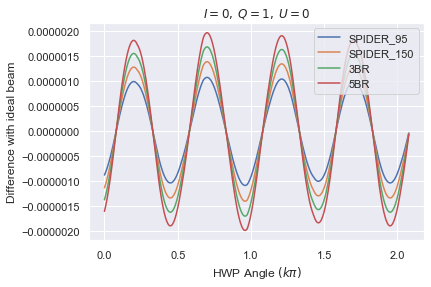

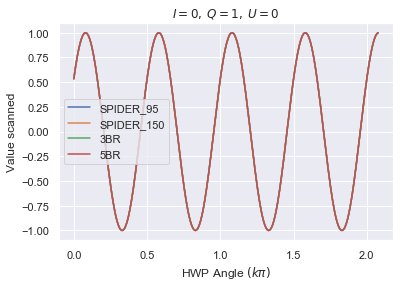

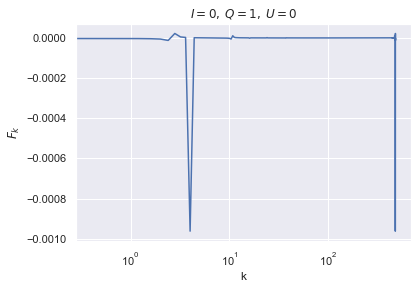

In [12]:
plt.figure(1)
plt.title(r'$I=0,\:Q=1, \:U=0$')
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[0,:500]-bideal.tod[:500])
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[1,:500]-bideal.tod[:500])
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[2,:500]-bideal.tod[:500])
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[3,:500]-bideal.tod[:500])

plt.xlabel(r'HWP Angle $( k\pi)$')
plt.ylabel('Difference with ideal beam')
#plt.ylabel('Difference with ideal hwp for Spider 150 hwp')
plt.legend(hwp_models)

plt.figure(2)
plt.title(r'$I=0,\:Q=1,\:U=0$')
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[0,:500])
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[1,:500])
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[2,:500])
plt.plot(np.arange(500)*fhwp_rot/fsamp *2 ,tod_res[3,:500])

plt.xlabel(r'HWP Angle $(k\pi)$')
plt.ylabel('Value scanned')
plt.legend(hwp_models+('ideal',))
#plt.legend(('SPIDER_150','ideal'))

plt.figure(3)
plt.title(r'$I=0,\:Q=1,\:U=0$')
xf = np.linspace(0.0, 1.0/(fhwp_rot/fsamp), bideal.tod.size)
plt.xlabel('k')
plt.ylabel(r'$F_k$')
plt.semilogx(xf, fft(tod_res[3,:]-bideal.tod))

We can also look at what the final product of a proper scan looks like, i.e. a map: 

Before starting the scanning simulation, we need to invoke some model of the underlying sky. For this example, we describe the sky as statistically isotropic and Gaussian I, Q, and U fields (with underlying power spectra and correlations as determined in the WMAP 7-year release).

## Effect on maps

In [52]:
cls = np.loadtxt('../ancillary/wmap7_r0p03_lensed_uK_ext.txt',
                 unpack=True) # Cl in uK^2
lmax=700 
ell, cls = cls[0], cls[1:]
np.random.seed(25) 
alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True) # uK

Here we set parameters that describe the pointing, the instrument and the beams. For this example, we just pick identical symmetric Gaussian beams with no cross-polarization. This will later allow us to easily check whether the code reproduces this known case.

In [59]:
fwhm = 40
spider_hwp = Beam().hwp()
spider_hwp.choose_HWP_model('SPIDER_95')
ideal_beam_opts = dict(lmax=lmax,
                 fwhm=fwhm,       # Gaussian co-pol beam, so only specify FWHM (arcmin)
                 btype='Gaussian', sensitive_freq=95.)
beam_opts = dict(lmax=lmax,
                 fwhm=fwhm,       # Gaussian co-pol beam, so only specify FWHM (arcmin)
                 btype='Gaussian',hwp=spider_hwp, sensitive_freq=95.)
spin_opts = dict(max_spin=2,      # Symmetric beams, so 2 is sufficient
                 nside_spin=256)  # nside of scanned maps 

scan_opts = dict(ra0=[-10],       # Center of scan
                 dec0=[-57.5],
                 az_throw=50,     # Scan width
                 scan_speed=1,
                 verbose=0)

mlen        = 24 * 60 * 60        # Mission length in seconds
rot_period  = 6 * 60 * 60
step_period = 1.5 * 60 * 60

An seasoned experimentalist might notice that we are defining scan regions and parameters that are not very dissimilar from that of the BICEP class of experiments. These experiments scan around 1-2% of the sky. Now that we have defined some of the boundary conditions of our experiment, we can start initializing scan strategy objects.

In [60]:
bideal = ScanStrategy(duration=mlen,
                  sample_rate=12.01, # sample rate in Hz
                  location='spole')  # Instrument at south pole (preset)
bnideal = ScanStrategy(duration=mlen,
                  sample_rate=12.01, # sample rate in Hz
                  location='spole')  # Instrument at south pole (preset)

# Create a 3 x 3 square grid of Gaussian beams (f.o.v. is 3 degrees)
bideal.create_focal_plane(nrow=3, ncol=3, fov=3, no_pairs=True,**ideal_beam_opts)
bnideal.create_focal_plane(nrow=3, ncol=3, fov=3, no_pairs=True,**beam_opts)

# Calculate tods in two chunks
chunks = bideal.partition_mission(0.5*bideal.mlen*bideal.fsamp) 
nideal_chunks = bnideal.partition_mission(0.5*bnideal.mlen*bnideal.fsamp) 
# Allocate and assign parameters for mapmaking
bideal.allocate_maps(nside=256)
bnideal.allocate_maps(nside=256)

bideal.set_instr_rot(period=rot_period, angles=[68, 113, 248, 293])
bnideal.set_instr_rot(period=rot_period, angles=[68, 113, 248, 293])
# Set elevation stepping
bideal.set_el_steps(step_period, steps=[-4, -3, -2, -1, 0, 1, 2, 3, 4, 4])
bnideal.set_el_steps(step_period, steps=[-4, -3, -2, -1, 0, 1, 2, 3, 4, 4])
# Set HWP modulation
bideal.set_hwp_mod(mode='continuous', freq=1.)#mode='continuous'
bnideal.set_hwp_mod(mode='continuous', freq=1.)#mode='continuous'

Here we actually scan the sky. We also solve for the I, Q and U maps and calculate the condition number of the per-pixel projection matrix. This might take a minute on a single core. Notice that the half-wave plate's argument accepts two values, 'ideal' and 'non-ideal'. Other values will raise a ValueError() Default is ideal.

In [61]:
# Generate timestreams, bin them and store as attributes
start_time = time.time()
bideal.scan_instrument_mpi(alm, **scan_opts)
print(time.time()-start_time)
# Solve for the maps
ideal_maps, ideal_cond = bideal.solve_for_map()

start_time = time.time()
bnideal.scan_instrument_mpi(alm, **scan_opts)
print(time.time()-start_time)
maps, cond = bnideal.solve_for_map()

/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


29.005554914474487


/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


32.10424876213074


# Results

With the data generated and binned into maps, we can visualize the results. We plot the condition number map and the solved I, Q and U maps. We expect the condition number to be as low as possible (=2) for almost all pixels because of the continuous HWP rotation and the instrument rotation. We can see the differences between the non-ideal HWP model (top row) and the ideal one (bottom row).

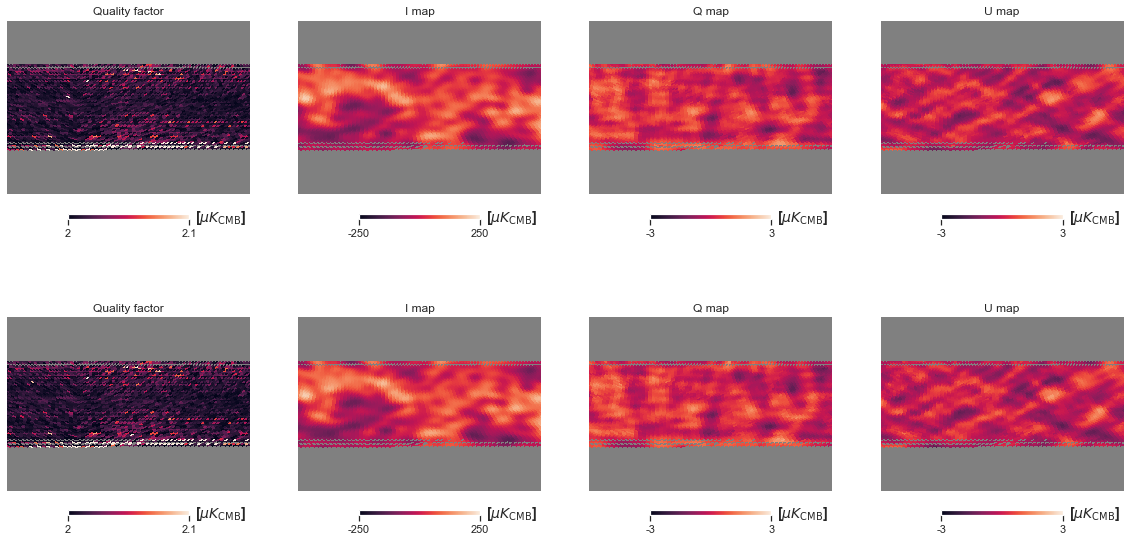

In [66]:
cond[cond == np.inf] = hp.UNSEEN
cart_opts = dict(unit=r'[$\mu K_{\mathrm{CMB}}$]', lonra=[-25, 10], latra=[-70, -45], hold=True)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))

ideal_cond[ideal_cond == np.inf] = hp.UNSEEN
plt.axes(axs[0,0])
hp.cartview(ideal_cond, min=2, max=5, title='Quality factor', **cart_opts)
plt.axes(axs[0,1])
hp.cartview(ideal_maps[0], min=-250, max=250, title='I map', **cart_opts)
plt.axes(axs[0,2])
hp.cartview(ideal_maps[1], min=-3, max=3, title='Q map', **cart_opts)
plt.axes(axs[0,3])
hp.cartview(ideal_maps[2], min=-3, max=3, title='U map', **cart_opts)

plt.axes(axs[1,0])
hp.cartview(cond, min=2, max=5, title='Quality factor', **cart_opts)
plt.axes(axs[1,1])
hp.cartview(maps[0], min=-250, max=250, title='I map', **cart_opts)
plt.axes(axs[1,2])
hp.cartview(maps[1], min=-3, max=3, title='Q map', **cart_opts)
plt.axes(axs[1,3])
hp.cartview(maps[2], min=-3, max=3, title='U map', **cart_opts)

We can see leakeage between I and Q/U in the non-ideal map (usually) compared to the ideal HWP case. 

Finally, we can check the results by comparing them to the smoothed input map by plotting difference maps.

In [64]:
hp.smoothalm(alm, fwhm=np.radians(fwhm / 60.))
sm_in = hp.alm2map(alm, hp.get_nside(maps[0]))
ideal_diff = ideal_maps - sm_in
diff = maps - sm_in

Sigma is 16.986436 arcmin (0.004941 rad) 
-> fwhm is 40.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


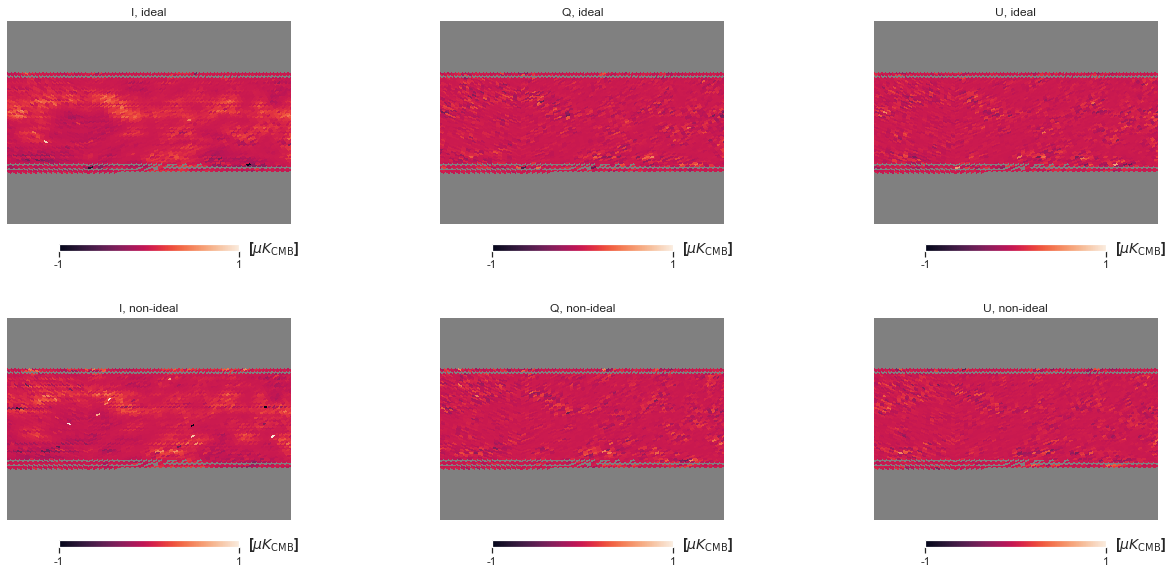

In [65]:
fig2, axs2 = plt.subplots(ncols=3, nrows=2, figsize=(22, 10))
plt.axes(axs2[0,0])
hp.cartview(ideal_diff[0], min=-1, max=1, title='I, ideal', **cart_opts)
plt.axes(axs2[0,1])
hp.cartview(ideal_diff[1], min=-1, max=1, title='Q, ideal', **cart_opts)
plt.axes(axs2[0,2])
hp.cartview(ideal_diff[2], min=-1, max=1, title='U, ideal', **cart_opts)
plt.axes(axs2[1,0])
hp.cartview(diff[0], min=-1, max=1, title='I, non-ideal', **cart_opts)
plt.axes(axs2[1,1])
hp.cartview(diff[1], min=-1, max=1, title='Q, non-ideal', **cart_opts)
plt.axes(axs2[1,2])
hp.cartview(diff[2], min=-1, max=1, title='U, non-ideal', **cart_opts)

We mostly recover the input. 


# Several Birefringent layers
What happens if our HWP has more than one birefringent layer ?

First, let's define a HWP. It has 3 layers of sapphire, each 3.14 mm thick. With the total thickness, it should be optimal for a 150GHz beam.

In [57]:
beamy = Beam(name='beamy', sensitive_freq=150) 
beamy.set_hwp_mueller(model_name='3BR')
print(beamy)
print(beamy.hwp)
print(beamy.hwp.stack)
print(beamy.hwp_mueller)

name    : beamy 
btype   : Gaussian 
alive   : True 
FWHM    : 43.2 arcmin 
az      : 0.0 deg 
el      : 0.0 deg 
polang  : 0.0 deg
po_file : None 



______________________________________________________


Layer 1: Thickness 0.000500


Material: fiducial AR
Material Type: isotropic
Refractive Index: 1.268000
Loss tangent: 0.001200


______________________________________________________

Layer 2: Thickness 0.000310


Material: fiducial AR
Material Type: isotropic
Refractive Index: 1.979000
Loss tangent: 0.001200


______________________________________________________

Layer 3: Thickness 0.000257


Material: fiducial AR
Material Type: isotropic
Refractive Index: 2.855000
Loss tangent: 0.001200


______________________________________________________

Layer 4: Thickness 0.003750


Material: Sapphire at 4K
Material Type: uniaxial
Refractive Index (ordinary): 3.019000
Refractive Index (extraordinary): 3.336000
Loss Tangent (ordinary): 0.000230
Loss Tangent (extraordinary): 0.000125


	 

We see off-block elements are important in our understanding of the AHWP. What effect do they have on mapmaking? 

In [21]:
scan_opts = dict(ra0=[-10], dec0=[-57.5],az_throw=50, scan_speed=1,verbose=0)
bfull = ScanStrategy(duration=mlen, sample_rate=12.01, location='spole')  

beam_opts = dict(lmax=lmax,
                 fwhm=fwhm,       # Gaussian co-pol beam, so only specify FWHM (arcmin)
                 btype='Gaussian',hwp=ahwp, sensitive_freq=150.)
bfull.create_focal_plane(nrow=2, ncol=2, fov=3, no_pairs=True,**beam_opts)
for beam in bfull.beams:
    beam[0].set_hwp_mueller(model_name='3BR')
    beam[1].set_hwp_mueller(model_name='3BR')
bfull_chunks = bnideal.partition_mission(0.5*bfull.mlen*bfull.fsamp) 

bfull.allocate_maps(nside=256)


# Set elevation stepping
bfull.set_el_steps(step_period, steps = np.linspace(-4,4,401))
# Set HWP modulation
bfull.set_hwp_mod(mode='continuous', freq=1.)#mode='continuous'

bfull.scan_instrument_mpi(alm, **scan_opts)
full_maps, full_cond = bfull.solve_for_map()

/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


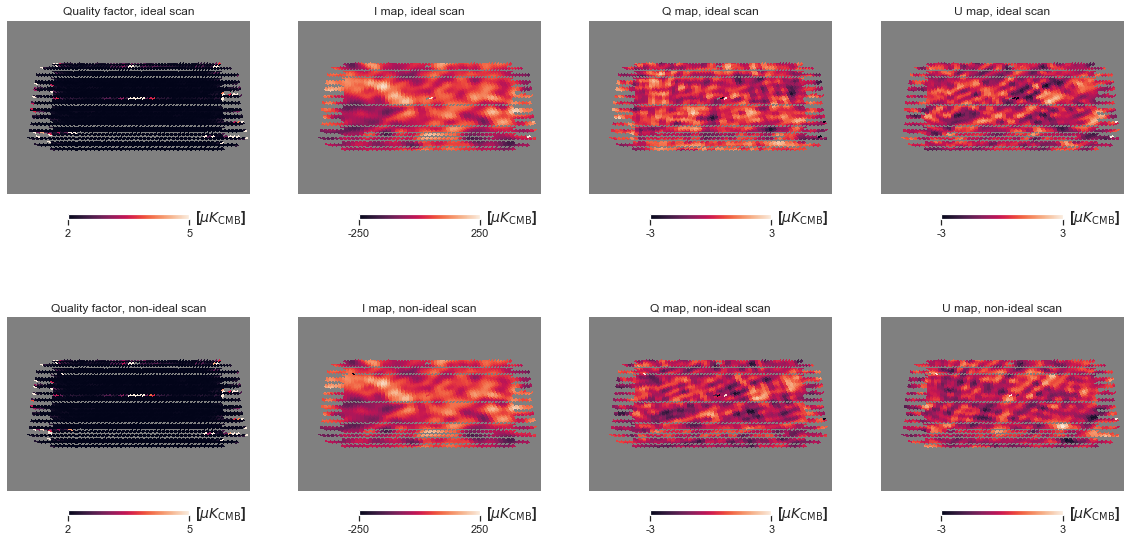

In [22]:
cond[cond == np.inf] = hp.UNSEEN
cart_opts = dict(unit=r'[$\mu K_{\mathrm{CMB}}$]', lonra=[-25, 10], latra=[-70, -45], hold=True)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))

ideal_cond[ideal_cond == np.inf] = hp.UNSEEN
plt.axes(axs[0,0])
hp.cartview(ideal_cond, min=2, max=5, title='Quality factor, ideal scan', **cart_opts)
plt.axes(axs[0,1])
hp.cartview(ideal_maps[0], min=-250, max=250, title='I map, ideal scan', **cart_opts)
plt.axes(axs[0,2])
hp.cartview(ideal_maps[1], min=-3, max=3, title='Q map, ideal scan', **cart_opts)
plt.axes(axs[0,3])
hp.cartview(ideal_maps[2], min=-3, max=3, title='U map, ideal scan', **cart_opts)

plt.axes(axs[1,0])
hp.cartview(full_cond, min=2, max=5, title='Quality factor, non-ideal scan', **cart_opts)
plt.axes(axs[1,1])
hp.cartview(full_maps[0], min=-250, max=250, title='I map, non-ideal scan', **cart_opts)
plt.axes(axs[1,2])
hp.cartview(full_maps[1], min=-3, max=3, title='Q map, non-ideal scan', **cart_opts)
plt.axes(axs[1,3])
hp.cartview(full_maps[2], min=-3, max=3, title='U map, non-ideal scan', **cart_opts)

The I map looks ok, the other two are wide off the mark! Clearly we need a way to substract the rotation offset inherent to AHWPs. This is done by passing a `varphi` argument to the `Beam.set_hwp_mod()` method.

In [23]:
scan_opts = dict(ra0=[-10], dec0=[-57.5],az_throw=20, scan_speed=1,verbose=0)
bfull = ScanStrategy(duration=mlen, sample_rate=12.01, location='spole')  
ahwp = Beam().hwp()
ahwp.choose_HWP_model('3BR')
beam_opts = dict(lmax=lmax,
                 fwhm=fwhm,       # Gaussian co-pol beam, so only specify FWHM (arcmin)
                 btype='Gaussian',hwp=ahwp, sensitive_freq=150.)
bfull.create_focal_plane(nrow=2, ncol=2, fov=3, no_pairs=True,**beam_opts)

bfull_chunks = bnideal.partition_mission(0.5*bfull.mlen*bfull.fsamp) 

bfull.allocate_maps(nside=256)

bfull.set_instr_rot(period=rot_period, angles=[0,30, 60, 90, 60, 30, 0])
# Set elevation stepping
bfull.set_el_steps(step_period, steps=[-4,-3,-2,-1,0,1,2,3,4])
# Set HWP modulation
bfull.set_hwp_mod(mode='continuous', freq=1., varphi=32.51)#phase in degrees
bfull.scan_instrument_mpi(alm, **scan_opts)
full_maps, full_cond = bfull.solve_for_map()

/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


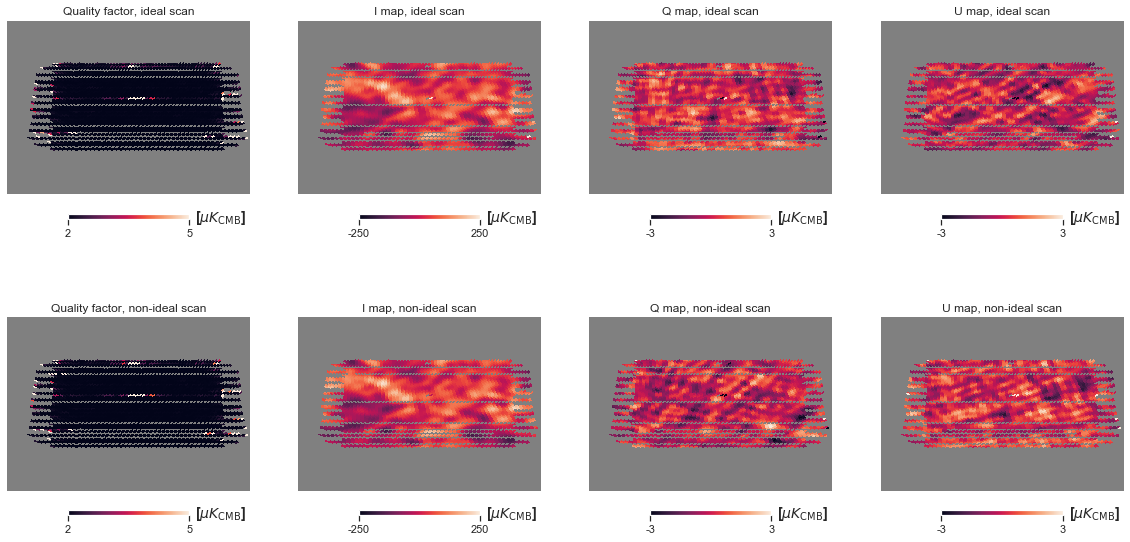

In [24]:
cond[cond == np.inf] = hp.UNSEEN
cart_opts = dict(unit=r'[$\mu K_{\mathrm{CMB}}$]', lonra=[-25, 10], latra=[-70, -45], hold=True)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))

ideal_cond[ideal_cond == np.inf] = hp.UNSEEN
plt.axes(axs[0,0])
hp.cartview(ideal_cond, min=2, max=5, title='Quality factor, ideal scan', **cart_opts)
plt.axes(axs[0,1])
hp.cartview(ideal_maps[0], min=-250, max=250, title='I map, ideal scan', **cart_opts)
plt.axes(axs[0,2])
hp.cartview(ideal_maps[1], min=-3, max=3, title='Q map, ideal scan', **cart_opts)
plt.axes(axs[0,3])
hp.cartview(ideal_maps[2], min=-3, max=3, title='U map, ideal scan', **cart_opts)

plt.axes(axs[1,0])
hp.cartview(full_cond, min=2, max=5, title='Quality factor, non-ideal scan', **cart_opts)
plt.axes(axs[1,1])
hp.cartview(full_maps[0], min=-250, max=250, title='I map, non-ideal scan', **cart_opts)
plt.axes(axs[1,2])
hp.cartview(full_maps[1], min=-3, max=3, title='Q map, non-ideal scan', **cart_opts)
plt.axes(axs[1,3])
hp.cartview(full_maps[2], min=-3, max=3, title='U map, non-ideal scan', **cart_opts)

Better.